In [1]:
import numpy as np
import os
import glob
import re
from scipy import interpolate

In [2]:
def modecount_rebin(kk, pk, modes, minmodes=20, ndesired=200): #from MP-Gadget
    """Rebins a power spectrum so that there are sufficient modes in each bin"""
    assert np.all(kk) > 0
    logkk=np.log10(kk)
    mdlogk = (np.max(logkk) - np.min(logkk))/ndesired
    istart=iend=1
    count=0
    k_list=[kk[0]]
    pk_list=[pk[0]]
    targetlogk=mdlogk+logkk[istart]
    while iend < np.size(logkk)-1:
        count+=modes[iend]
        iend+=1
        if count >= minmodes and logkk[iend-1] >= targetlogk:
            pk1 = np.sum(modes[istart:iend]*pk[istart:iend])/count
            kk1 = np.sum(modes[istart:iend]*kk[istart:iend])/count
            k_list.append(kk1)
            pk_list.append(pk1)
            istart=iend
            targetlogk=mdlogk+logkk[istart]
            count=0
    k_list = np.array(k_list)
    pk_list = np.array(pk_list)
    return (k_list, pk_list)

def load_rebin(spec_file):
    k_raw, Pk_raw, modes = np.loadtxt(spec_file, usecols=(0,1,2), unpack=True)
    k, Pk = modecount_rebin(k_raw, Pk_raw, modes)
    return k, Pk

In [3]:
def load_interpolate(dir_base, k_cut, zs_obj, flatten=False):
    z_max = np.max(zs_obj)
    a_min = 1/(1+z_max)
    # get the list of files
    dir_sims = glob.glob(os.path.join(dir_base+'*'))

    # exclude the dirs that do not match the pattern: *_#### where #### is %04d
    dir_sims = [d for d in dir_sims if d[-5] == '_' and d[-4:].isdigit()]

    # sort the directories
    dir_sims.sort()

    lgP_sims_obj = []
    # loop over the directories and load the data
    for d in dir_sims:
        # data files of this simulation
        file_list = glob.glob(os.path.join(d,"output/powerspectrum-*.txt"))
        file_list.sort()

        print("Loading data from %s" % d)
        data_sim = []
        scale_factors = []

        for filepath in file_list:
            match = re.search(r"powerspectrum-([0-9]+\.[0-9]{4})\.txt", filepath)
            if match:
                scale_factor = float(match.group(1))
                if scale_factor < a_min:
                    continue
                k, Pk = load_rebin(filepath)
                data_sim.append(Pk)
                scale_factors.append(scale_factor)

        # Convert to NumPy arrays
        data_sim = np.array(data_sim)          # shape: (K, N, M)
        scale_factors = np.array(scale_factors)   # shape: (K,)
        zs = 1 / scale_factors - 1

        # cut off the high k part, keep only k<=k_cut, include k_cut within the data
        len_k = len(k[k<=k_cut]) + 1
        k = k[:len_k]
        data_sim = data_sim[:,:len(k)]

        # interpolate the data
        data_sim_obj = np.zeros((len(zs_obj), len(k)))
        for i in range(data_sim.shape[1]):
            f = interpolate.interp1d(zs, np.log10(data_sim[:,i]), kind='linear')
            data_sim_obj[:,i] = 10**f(zs_obj)

        # convert to log space
        lgk = np.log10(k)
        lgP_sim_obj = np.log10(data_sim_obj)

        # interpolate over lgk evenly spaced
        lgk_new = np.linspace(lgk.min(), lgk.max(), len(k))
        lgP_sim_obj_new = np.zeros((len(zs_obj), len(lgk_new)))
        for i in range(len(zs_obj)):
            f = interpolate.interp1d(lgk, lgP_sim_obj[i], kind='linear')
            lgP_sim_obj_new[i] = f(lgk_new)

        # flatten the data
        if flatten:
            lgP_sim_obj_new = lgP_sim_obj_new.flatten()
        lgP_sims_obj.append(lgP_sim_obj_new)

    return lgk_new, np.array(lgP_sims_obj)

In [4]:
lna_obj = np.linspace(np.log(1), np.log(1/(1+3)), 30)
zs_obj = 1/np.exp(lna_obj) - 1
zs_old = [0, 0.2, 0.5, 1, 2, 3]
# insert the old zs_obj into the new zs_obj
zs_obj = np.sort(np.append(zs_obj, zs_old))
# remove duplicates
zs_obj = np.unique(zs_obj)

In [5]:
zs_obj.shape

(34,)

In [6]:
zs_obj

array([0.        , 0.04896426, 0.10032601, 0.15420265, 0.2       ,
       0.21071733, 0.2699992 , 0.33218376, 0.39741315, 0.46583644,
       0.5       , 0.53761003, 0.61289796, 0.69187231, 0.77471358,
       0.86161111, 0.95276351, 1.        , 1.04837912, 1.14867648,
       1.25388482, 1.36424461, 1.48000809, 1.60143984, 1.72881741,
       1.86243192, 2.        , 2.00258876, 2.14960829, 2.30382651,
       2.46559592, 2.63528624, 2.81328532, 3.        ])

In [7]:
def save_data(dir, x, y, k):
    if not os.path.exists(dir):
        os.makedirs(dir)
    np.savetxt(os.path.join(dir, 'train_input.txt'), x)
    np.savetxt(os.path.join(dir, 'train_output.txt'), y)
    np.savetxt(os.path.join(dir, 'kf.txt'), k)
    np.savetxt(os.path.join(dir, 'zs.txt'), zs_obj)

In [8]:
# # Goku-N
# # load data and interpolate (loop over all cosmologies)
# # L1A
# dir_l1_base = '/home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box1000_Part750'
# # zs_obj = zs_obj = np.linspace(0, 3, 40) # 40 redshifts


# x_l = np.loadtxt('./narrow/matter_power_564_Box1000_Part750_15_Box1000_Part3000_z0/train_input_fidelity_0.txt')
# k_cut = 1.5
# lgk_l1A, y_l1A = load_interpolate(dir_l1_base, k_cut, zs_obj) # lgk and lgP

# # L2
# dir_l2_base = '/home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box250_Part750'
# # zs_obj = zs_obj = np.linspace(0, 3, 40) # 40 redshifts
# # x_l2 = np.loadtxt('./narrow/matter_power_564_Box1000_Part750_15_Box1000_Part3000_z0/train_input_fidelity_0.txt')
# k_cut = 11
# lgk_l2, y_l2 = load_interpolate(dir_l2_base, k_cut, zs_obj)

# # output data
# dir_L1A = "N_L1A_c1.5"
# dir_L2 = "N_L2"

# # dirs to save data
# dir_L1HAr = "N_L1HAr_c1.5"
# dir_L2Hr = "N_L2Hr"

# dir_H = "N_H"  # HF data (not used for training, only for testing)

# # load HF data
# dir_h_base = '/home/yang/Desktop/Goku_matter_pow/narrow/matter_power/cosmo_10p_Box1000_Part3000'
# x_h = np.loadtxt('./narrow/matter_power_564_Box1000_Part750_15_Box1000_Part3000_z0/train_input_fidelity_1.txt')
# k_cut = 15
# lgk_h, y_h = load_interpolate(dir_h_base, k_cut, zs_obj, flatten=0) # lgk and lgP

In [9]:
# Goku-W

# load data and interpolate (loop over all cosmologies)
# L1A
dir_l1_base = '/home/yang/Desktop/Goku_matter_pow/wide/matter_power/cosmo_10p_Box1000_Part750'
# zs_obj = zs_obj = np.linspace(0, 3, 40) # 40 redshifts


x_l = np.loadtxt('./wide/matter_power_564_Box1000_Part750_21_Box1000_Part3000_z0/train_input_fidelity_0.txt')
k_cut = 1.5
lgk_l1A, y_l1A = load_interpolate(dir_l1_base, k_cut, zs_obj) # lgk and lgP

# L2
dir_l2_base = '/home/yang/Desktop/Goku_matter_pow/wide/matter_power/cosmo_10p_Box250_Part750'
# zs_obj = zs_obj = np.linspace(0, 3, 40) # 40 redshifts
# x_l2 = np.loadtxt('./narrow/matter_power_564_Box1000_Part750_15_Box1000_Part3000_z0/train_input_fidelity_0.txt')
k_cut = 11
lgk_l2, y_l2 = load_interpolate(dir_l2_base, k_cut, zs_obj)

# output data
dir_L1A = "W_L1A"
dir_L2 = "W_L2"

# dirs to save data
dir_L1HAr = "W_L1HAr"
dir_L2Hr = "W_L2Hr"

dir_H = "W_H"  # HF data (not used for training, only for testing)

# load HF data
dir_h_base = '/home/yang/Desktop/Goku_matter_pow/wide/matter_power/cosmo_10p_Box1000_Part3000'
x_h = np.loadtxt('./wide/matter_power_564_Box1000_Part750_15_Box1000_Part3000_z0/train_input_fidelity_1.txt')
k_cut = 15
lgk_h, y_h = load_interpolate(dir_h_base, k_cut, zs_obj, flatten=0) # lgk and lgP

Loading data from /home/yang/Desktop/Goku_matter_pow/wide/matter_power/cosmo_10p_Box1000_Part750_0000
Loading data from /home/yang/Desktop/Goku_matter_pow/wide/matter_power/cosmo_10p_Box1000_Part750_0001
Loading data from /home/yang/Desktop/Goku_matter_pow/wide/matter_power/cosmo_10p_Box1000_Part750_0002
Loading data from /home/yang/Desktop/Goku_matter_pow/wide/matter_power/cosmo_10p_Box1000_Part750_0003
Loading data from /home/yang/Desktop/Goku_matter_pow/wide/matter_power/cosmo_10p_Box1000_Part750_0004
Loading data from /home/yang/Desktop/Goku_matter_pow/wide/matter_power/cosmo_10p_Box1000_Part750_0005
Loading data from /home/yang/Desktop/Goku_matter_pow/wide/matter_power/cosmo_10p_Box1000_Part750_0006
Loading data from /home/yang/Desktop/Goku_matter_pow/wide/matter_power/cosmo_10p_Box1000_Part750_0007
Loading data from /home/yang/Desktop/Goku_matter_pow/wide/matter_power/cosmo_10p_Box1000_Part750_0008
Loading data from /home/yang/Desktop/Goku_matter_pow/wide/matter_power/cosmo_10p_B

FileNotFoundError: ./wide/matter_power_564_Box1000_Part750_15_Box1000_Part3000_z0/train_input_fidelity_1.txt not found.

In [ ]:
def interp_k_bins(lgk, lgP, lgk_h):
    # find the k bins in lgk_h that are in the range of lgk
    idx = np.where((lgk_h >= lgk.min()) & (lgk_h <= lgk.max()))[0]
    lgk_common = lgk_h[idx]

    # interpolate the lgP data to the common k bins
    f = interpolate.interp1d(lgk, lgP, kind='linear')
    lgP_interp = f(lgk_common)
    return lgk_common, lgP_interp

In [ ]:
# interpolate the LF data to the HF k bins
lgk_l1A, y_l1A = interp_k_bins(lgk_l1A, y_l1A, lgk_h)
lgk_l2, y_l2 = interp_k_bins(lgk_l2, y_l2, lgk_h)


Text(0.5, 1.0, 'L1A')

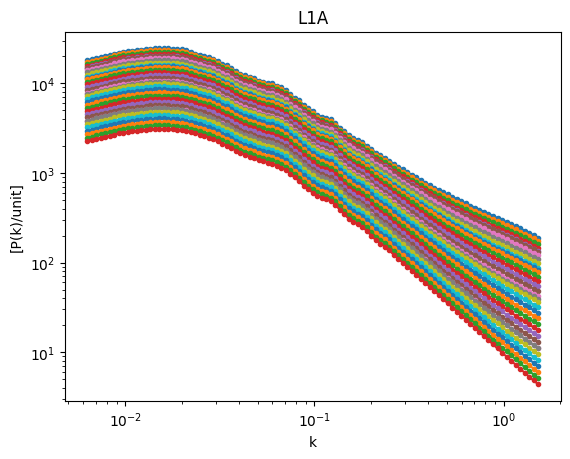

In [ ]:
# plot L1A cosmo 0
import matplotlib.pyplot as plt
plt.figure()

# loop over all redshifts
for i in range(len(zs_obj)):
    # plt.plot(k_l1A, y_l1A[i_start:i_end], label='z=%.2f'%zs_obj[i])
    plt.plot(10**lgk_l1A, 10**y_l1A[0, i, :], '.-', label='z=%.2f'%zs_obj[i])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('[P(k)/unit]')
plt.title('L1A')

Text(0.5, 1.0, 'L2')

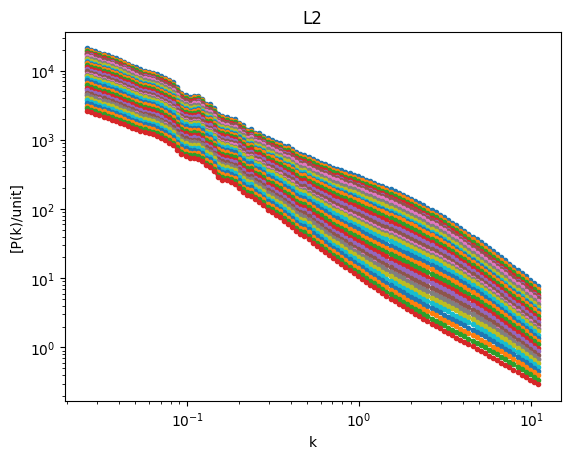

In [ ]:
# plot L2 cosmo 0
plt.figure()

# loop over all redshifts
for i in range(len(zs_obj)):
    # plt.plot(k_l2, y_l2[i_start:i_end], label='z=%.2f'%zs_obj[i])
    plt.plot(10**lgk_l2, 10**y_l2[0, i, :], '.-', label='z=%.2f'%zs_obj[i])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('[P(k)/unit]')
plt.title('L2')

In [ ]:
10**lgk_l2

array([ 0.02619061,  0.0276688 ,  0.02923043,  0.0308802 ,  0.03262307,
        0.03446432,  0.03640948,  0.03846443,  0.04063536,  0.04292882,
        0.04535172,  0.04791137,  0.05061549,  0.05347223,  0.0564902 ,
        0.0596785 ,  0.06304675,  0.06660511,  0.0703643 ,  0.07433566,
        0.07853116,  0.08296346,  0.08764591,  0.09259264,  0.09781857,
        0.10333944,  0.10917192,  0.11533358,  0.121843  ,  0.12871982,
        0.13598476,  0.14365973,  0.15176788,  0.16033366,  0.16938288,
        0.17894285,  0.18904238,  0.19971192,  0.21098366,  0.22289157,
        0.23547156,  0.24876156,  0.26280166,  0.27763417,  0.29330384,
        0.3098579 ,  0.32734627,  0.34582168,  0.36533984,  0.38595961,
        0.40774316,  0.43075616,  0.45506803,  0.48075205,  0.50788568,
        0.53655073,  0.56683363,  0.59882571,  0.63262341,  0.66832865,
        0.7060491 ,  0.74589848,  0.78799697,  0.83247149,  0.87945615,
        0.92909262,  0.98153058,  1.03692813,  1.09545232,  1.15

In [ ]:
lgk_l2.shape

(111,)

In [ ]:
# save data
# flatten axis 1 and 2 as a new data array
y_l1A_reshaped = y_l1A.reshape(y_l1A.shape[0], -1)
y_l2_reshaped = y_l2.reshape(y_l2.shape[0], -1)

save_data(dir_L1A, x_l, y_l1A_reshaped, lgk_l1A)
save_data(dir_L2, x_l, y_l2_reshaped, lgk_l2)

In [ ]:
10**lgk_l1A

array([0.00628319, 0.00663781, 0.00701245, 0.00740823, 0.00782635,
       0.00826807, 0.00873472, 0.00922771, 0.00974852, 0.01029873,
       0.01087999, 0.01149405, 0.01214278, 0.01282812, 0.01355213,
       0.01431702, 0.01512507, 0.01597873, 0.01688057, 0.0178333 ,
       0.01883982, 0.01990313, 0.02102647, 0.0222132 , 0.02346691,
       0.02479138, 0.02619061, 0.0276688 , 0.02923043, 0.0308802 ,
       0.03262307, 0.03446432, 0.03640948, 0.03846443, 0.04063536,
       0.04292882, 0.04535172, 0.04791137, 0.05061549, 0.05347223,
       0.0564902 , 0.0596785 , 0.06304675, 0.06660511, 0.0703643 ,
       0.07433566, 0.07853116, 0.08296346, 0.08764591, 0.09259264,
       0.09781857, 0.10333944, 0.10917192, 0.11533358, 0.121843  ,
       0.12871982, 0.13598476, 0.14365973, 0.15176788, 0.16033366,
       0.16938288, 0.17894285, 0.18904238, 0.19971192, 0.21098366,
       0.22289157, 0.23547156, 0.24876156, 0.26280166, 0.27763417,
       0.29330384, 0.3098579 , 0.32734627, 0.34582168, 0.36533

In [ ]:
lgk_l1A.shape

(101,)

In [ ]:
10**lgk_h

array([6.28319000e-03, 6.63781302e-03, 7.01245096e-03, 7.40823345e-03,
       7.82635388e-03, 8.26807302e-03, 8.73472278e-03, 9.22771023e-03,
       9.74852187e-03, 1.02987281e-02, 1.08799880e-02, 1.14940541e-02,
       1.21427781e-02, 1.28281161e-02, 1.35521345e-02, 1.43170165e-02,
       1.51250684e-02, 1.59787267e-02, 1.68805655e-02, 1.78333041e-02,
       1.88398151e-02, 1.99031336e-02, 2.10264658e-02, 2.22131988e-02,
       2.34669109e-02, 2.47913826e-02, 2.61906074e-02, 2.76688043e-02,
       2.92304307e-02, 3.08801952e-02, 3.26230723e-02, 3.44643173e-02,
       3.64094822e-02, 3.84644321e-02, 4.06353633e-02, 4.29288218e-02,
       4.53517230e-02, 4.79113727e-02, 5.06154889e-02, 5.34722253e-02,
       5.64901958e-02, 5.96785005e-02, 6.30467530e-02, 6.66051095e-02,
       7.03642996e-02, 7.43356582e-02, 7.85311602e-02, 8.29634561e-02,
       8.76459107e-02, 9.25926428e-02, 9.78185683e-02, 1.03339445e-01,
       1.09171920e-01, 1.15333579e-01, 1.21843002e-01, 1.28719817e-01,
      

In [ ]:
lgk_h.shape

(143,)

In [ ]:
y_l1A.shape

(564, 34, 101)

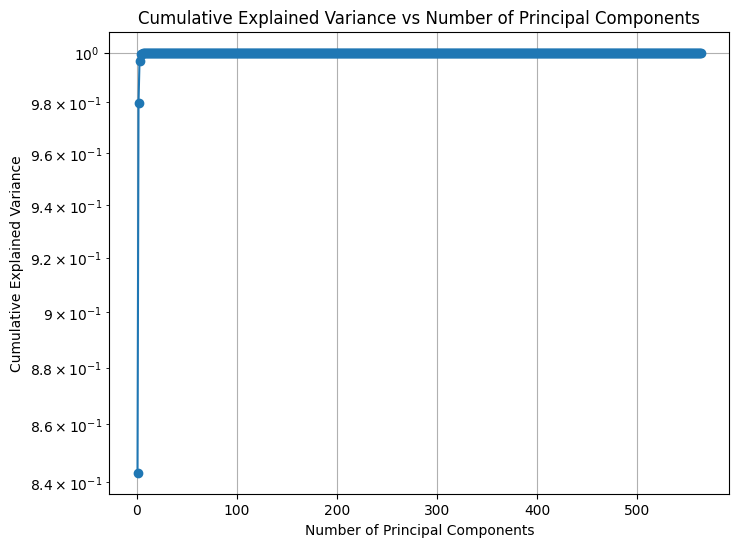

In [ ]:
# PCA L1A
from sklearn.decomposition import PCA


# Fit PCA without limiting number of components
pca = PCA()
pca.fit(y_l1A_reshaped)

# Explained variance ratio for each PC
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plotting the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
# y log scale
plt.yscale('log')
plt.title('Cumulative Explained Variance vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [ ]:
cumulative_variance

array([0.8432105 , 0.97998153, 0.99667296, 0.99934832, 0.9995979 ,
       0.99977328, 0.99990059, 0.99996849, 0.99997981, 0.99998665,
       0.99999068, 0.99999357, 0.99999554, 0.99999672, 0.99999754,
       0.99999828, 0.99999883, 0.99999916, 0.99999934, 0.99999945,
       0.99999953, 0.9999996 , 0.99999966, 0.9999997 , 0.99999973,
       0.99999976, 0.99999978, 0.99999979, 0.99999981, 0.99999983,
       0.99999984, 0.99999985, 0.99999986, 0.99999987, 0.99999988,
       0.99999989, 0.9999999 , 0.99999991, 0.99999992, 0.99999992,
       0.99999993, 0.99999993, 0.99999994, 0.99999994, 0.99999995,
       0.99999995, 0.99999996, 0.99999996, 0.99999996, 0.99999997,
       0.99999997, 0.99999997, 0.99999997, 0.99999998, 0.99999998,
       0.99999998, 0.99999998, 0.99999998, 0.99999998, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 1.        , 1.     

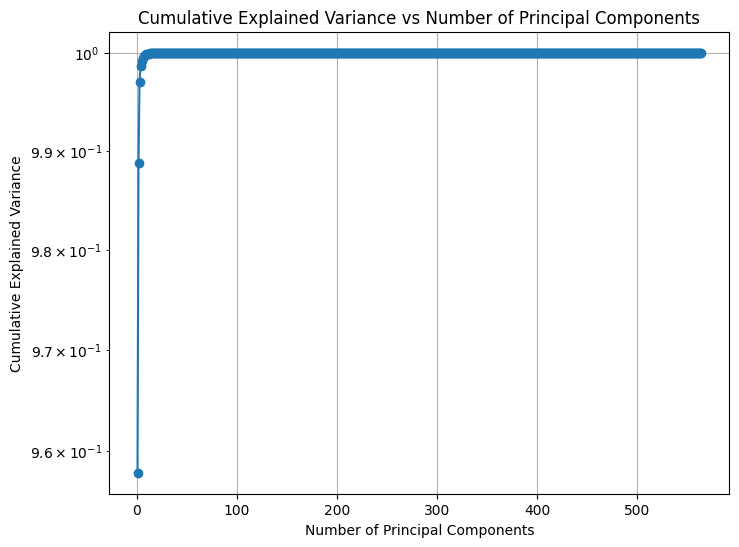

In [ ]:
# PCA L2

# Fit PCA without limiting number of components
pca = PCA()
pca.fit(y_l2_reshaped)

# Explained variance ratio for each PC
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plotting the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
# y log scale
plt.yscale('log')
plt.title('Cumulative Explained Variance vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [ ]:
cumulative_variance

array([0.95782304, 0.98877549, 0.99702502, 0.99863181, 0.99912829,
       0.99947434, 0.99962687, 0.99974946, 0.99983051, 0.99987375,
       0.99989718, 0.99991472, 0.99992995, 0.99994122, 0.99995031,
       0.99995692, 0.99996183, 0.99996612, 0.99996963, 0.99997258,
       0.99997535, 0.99997781, 0.99997985, 0.99998174, 0.99998334,
       0.99998485, 0.99998617, 0.99998718, 0.99998815, 0.99998903,
       0.9999898 , 0.9999905 , 0.99999113, 0.99999172, 0.99999226,
       0.99999278, 0.99999327, 0.99999372, 0.99999416, 0.99999453,
       0.99999487, 0.99999518, 0.99999549, 0.99999576, 0.99999601,
       0.99999625, 0.99999646, 0.99999667, 0.99999686, 0.99999703,
       0.99999718, 0.99999732, 0.99999746, 0.99999759, 0.99999771,
       0.99999782, 0.99999792, 0.99999802, 0.99999811, 0.9999982 ,
       0.99999827, 0.99999835, 0.99999842, 0.99999849, 0.99999856,
       0.99999862, 0.99999868, 0.99999874, 0.99999879, 0.99999884,
       0.99999889, 0.99999894, 0.99999898, 0.99999902, 0.99999

In [ ]:
lgk_h.shape

(143,)

In [ ]:
lgk_h

array([-2.20181981, -2.17797499, -2.15413016, -2.13028534, -2.10644052,
       -2.0825957 , -2.05875087, -2.03490605, -2.01106123, -1.98721641,
       -1.96337159, -1.93952676, -1.91568194, -1.89183712, -1.8679923 ,
       -1.84414747, -1.82030265, -1.79645783, -1.77261301, -1.74876819,
       -1.72492336, -1.70107854, -1.67723372, -1.6533889 , -1.62954407,
       -1.60569925, -1.58185443, -1.55800961, -1.53416479, -1.51031996,
       -1.48647514, -1.46263032, -1.4387855 , -1.41494067, -1.39109585,
       -1.36725103, -1.34340621, -1.31956139, -1.29571656, -1.27187174,
       -1.24802692, -1.2241821 , -1.20033728, -1.17649245, -1.15264763,
       -1.12880281, -1.10495799, -1.08111316, -1.05726834, -1.03342352,
       -1.0095787 , -0.98573388, -0.96188905, -0.93804423, -0.91419941,
       -0.89035459, -0.86650976, -0.84266494, -0.81882012, -0.7949753 ,
       -0.77113048, -0.74728565, -0.72344083, -0.69959601, -0.67575119,
       -0.65190636, -0.62806154, -0.60421672, -0.5803719 , -0.55

In [ ]:
lgk_l2

array([-1.58185443, -1.55800961, -1.53416479, -1.51031996, -1.48647514,
       -1.46263032, -1.4387855 , -1.41494067, -1.39109585, -1.36725103,
       -1.34340621, -1.31956139, -1.29571656, -1.27187174, -1.24802692,
       -1.2241821 , -1.20033728, -1.17649245, -1.15264763, -1.12880281,
       -1.10495799, -1.08111316, -1.05726834, -1.03342352, -1.0095787 ,
       -0.98573388, -0.96188905, -0.93804423, -0.91419941, -0.89035459,
       -0.86650976, -0.84266494, -0.81882012, -0.7949753 , -0.77113048,
       -0.74728565, -0.72344083, -0.69959601, -0.67575119, -0.65190636,
       -0.62806154, -0.60421672, -0.5803719 , -0.55652708, -0.53268225,
       -0.50883743, -0.48499261, -0.46114779, -0.43730297, -0.41345814,
       -0.38961332, -0.3657685 , -0.34192368, -0.31807885, -0.29423403,
       -0.27038921, -0.24654439, -0.22269957, -0.19885474, -0.17500992,
       -0.1511651 , -0.12732028, -0.10347545, -0.07963063, -0.05578581,
       -0.03194099, -0.00809617,  0.01574866,  0.03959348,  0.06

In [ ]:
y_h.shape

(15, 34, 143)

In [ ]:
# loop over the L1 input and find the ones (indices) that are in the HF input
indices = []
for i in range(len(x_l)):
    if x_l[i] in x_h:
        indices.append(i)

print(indices)


[144, 145, 146, 168, 169, 170, 195, 196, 197, 204, 205, 206, 336, 337, 338]


In [ ]:
# interpolate and ratio: y_HF / y_LF
# L1A
y_l1A_H = y_l1A[indices]
f = interpolate.interp1d(lgk_h, y_h, axis=2, kind='linear')
y_h_A = f(lgk_l1A)
r1A = 10**y_h_A / 10**y_l1A_H  # H cosmologies only

# L2
y_l2_H = y_l2[indices]
f = interpolate.interp1d(lgk_h, y_h, axis=2, kind='linear')
y_h_2 = f(lgk_l2)
r2 = 10**y_h_2 / 10**y_l2_H  # H cosmologies only

In [ ]:
r1A.shape

(15, 34, 101)

In [ ]:
# save data for ratio: L-H
# flatten axis 1 and 2 as a new data array
r1A_reshaped = r1A.reshape(r1A.shape[0], -1)
r2_reshaped = r2.reshape(r2.shape[0], -1)

save_data(dir_L1HAr, x_h, r1A_reshaped, lgk_l1A)
save_data(dir_L2Hr, x_h, r2_reshaped, lgk_l2)

# save HF data
y_h_reshaped = y_h.reshape(y_h.shape[0], -1)
save_data(dir_H, x_h, y_h_reshaped, lgk_h)



In [ ]:
r1A_reshaped.shape

(15, 3434)

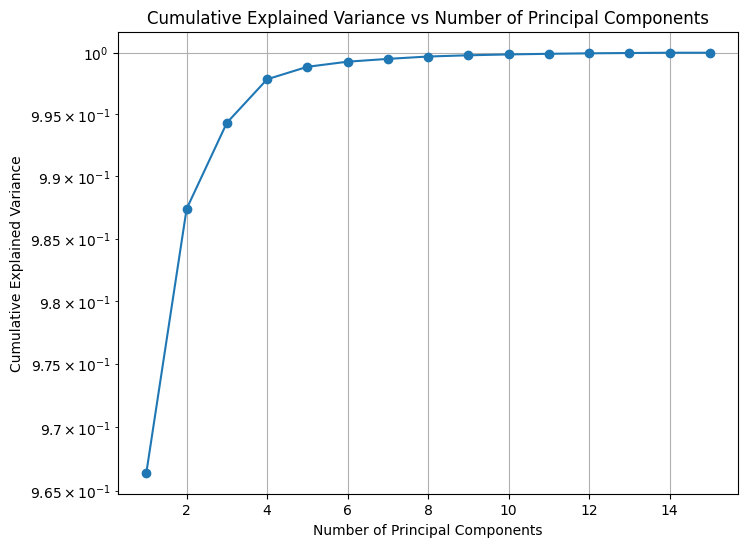

In [ ]:
# PCA L1A-H ratio

# Fit PCA without limiting number of components
pca = PCA()
pca.fit(r1A_reshaped)

# Explained variance ratio for each PC
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plotting the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
# y log scale
plt.yscale('log')
plt.title('Cumulative Explained Variance vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [ ]:
cumulative_variance

array([0.96642194, 0.98737875, 0.99431871, 0.99784346, 0.9988562 ,
       0.99927155, 0.99949872, 0.99969177, 0.9997917 , 0.99986108,
       0.99991149, 0.99995133, 0.99997656, 1.        , 1.        ])

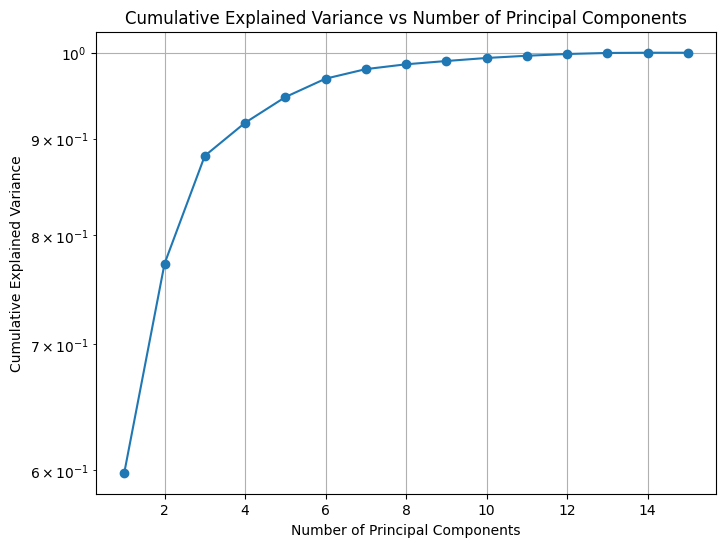

In [ ]:
# PCA L2-H ratio

# Fit PCA without limiting number of components
pca = PCA()
pca.fit(r2_reshaped)

# Explained variance ratio for each PC
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plotting the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
# y log scale
plt.yscale('log')
plt.title('Cumulative Explained Variance vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [ ]:
cumulative_variance

array([0.59832294, 0.7726083 , 0.88153817, 0.91787424, 0.94718317,
       0.96876935, 0.98015161, 0.98595055, 0.98990806, 0.99360259,
       0.99630311, 0.99843731, 0.99971043, 1.        , 1.        ])